In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import WaveNet
from deepseries.dataset import Property, TimeSeries, SeriesFrame
from deepseries.train import Learner
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error

info = pd.read_excel("./data/metric.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("./data/metric.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]

In [2]:
power = pd.read_csv('./data/power2.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

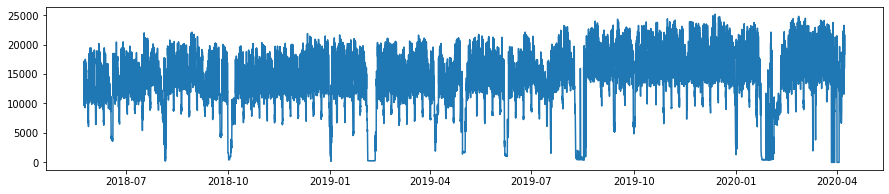

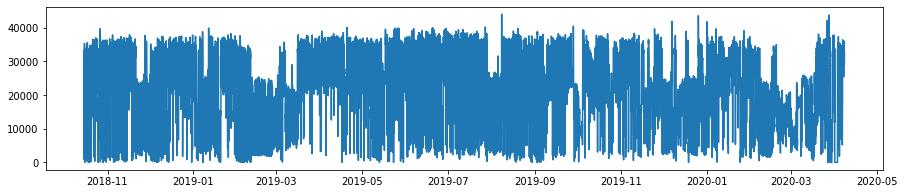

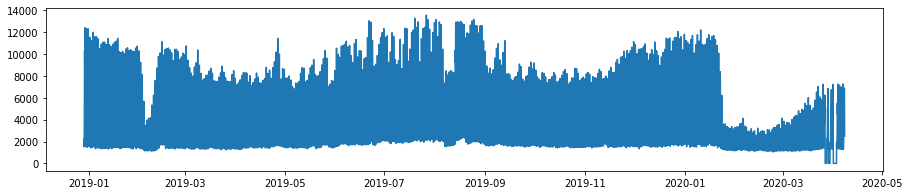

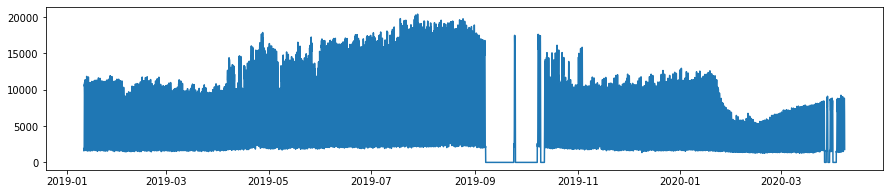

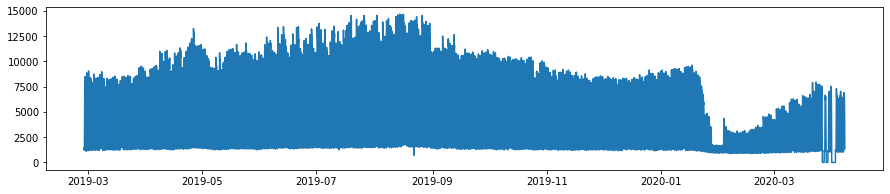

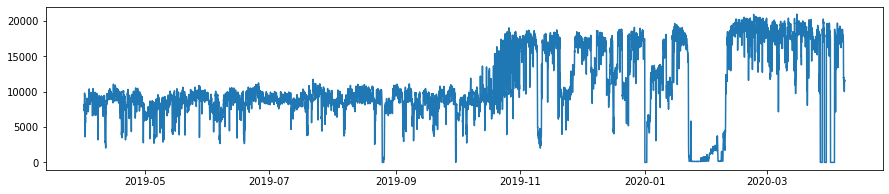

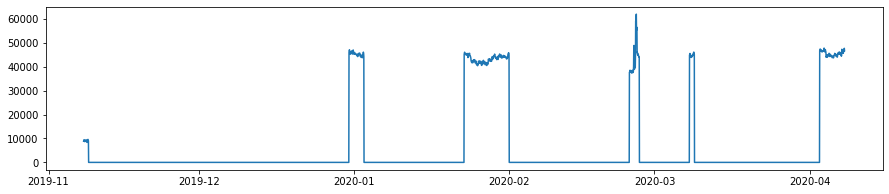

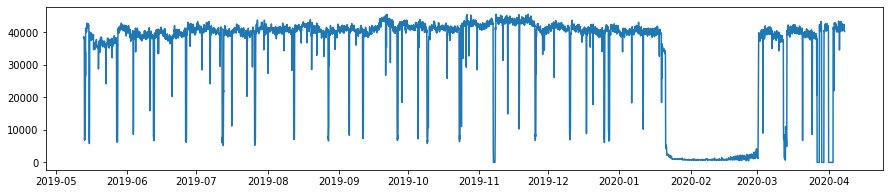

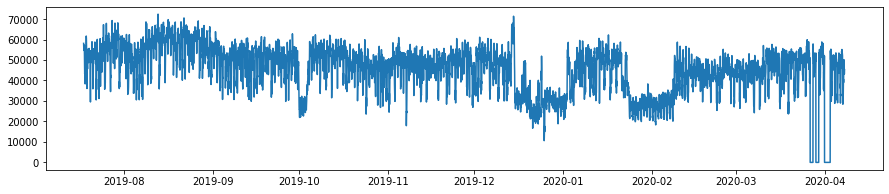

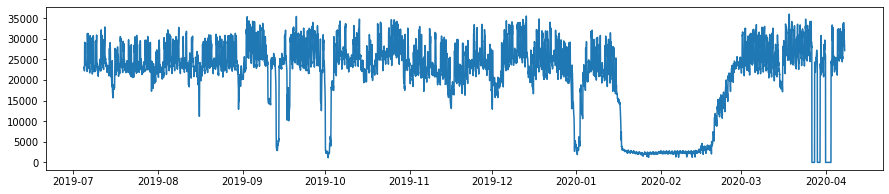

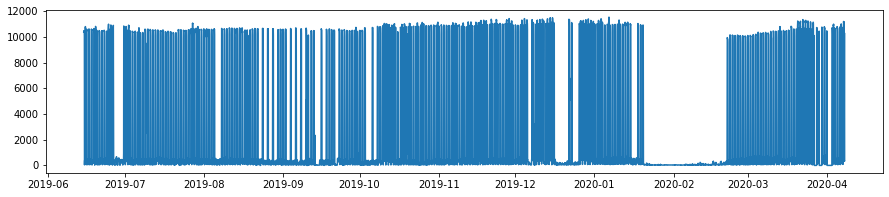

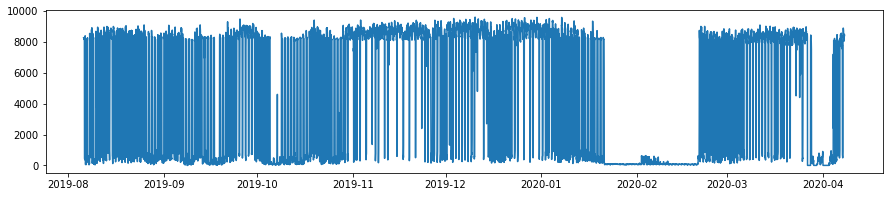

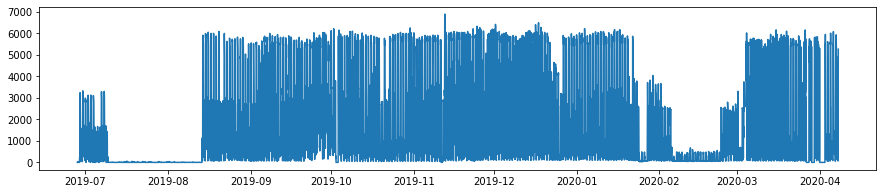

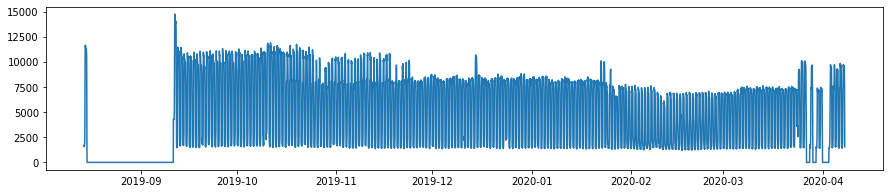

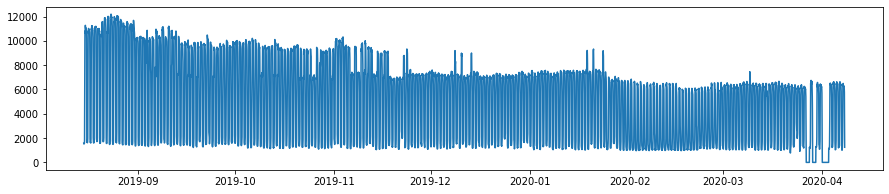

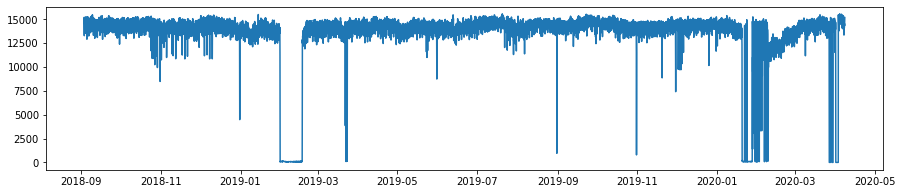

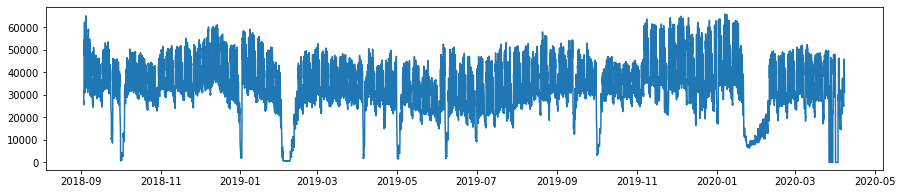

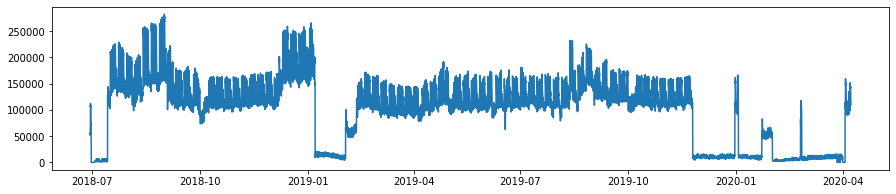

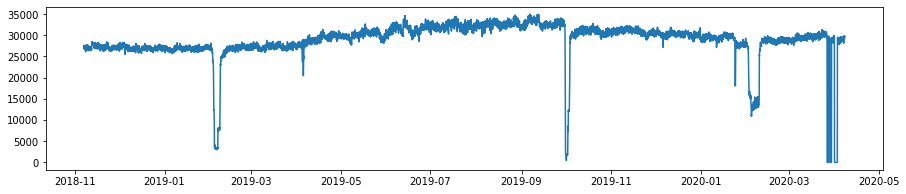

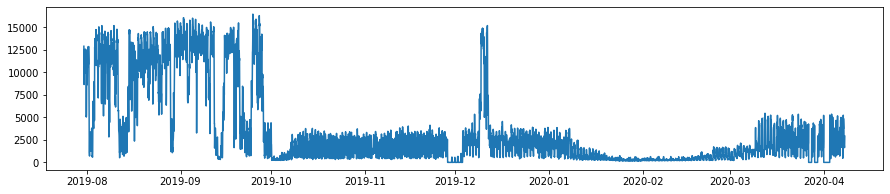

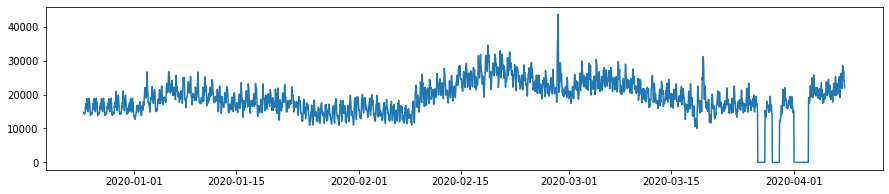

In [3]:
for cid in power.index:
    plt.figure(figsize=(15, 3))
    plt.plot(np.expm1(power.loc[cid]))

In [4]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 15
N_VALID = 24 * 15
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

In [5]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7)
x_lag14 = n_lag(xy, 14)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14], axis=1).astype("float32")

In [6]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


xy_weekday = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

xy_hour = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

xy_month = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    xy_weekday,
    xy_hour,
    xy_month,
    x_is_valid
], axis=1).astype('float32')

In [7]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_VALID)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, :, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, :, valid_idx])

train_x_features = TimeSeries(x_num_features[:, :, train_idx])
valid_x_features = TimeSeries(x_num_features[:, :, valid_idx])

train_frame = SeriesFrame(train_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN, 
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features])
valid_frame = SeriesFrame(valid_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN,
                         enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features])

test_xy = xy[:, :, test_idx]
test_xf = np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)
test_yf = xy_num_features[:, :, test_idx]

In [8]:
model = WaveNet()
opt = Adam(model.parameters(), 0.001)
loss_fn = nn.MSELoss()
# model.cuda()
learner = Learner(model, opt, loss_fn, '.', log_interval=20)
learner.fit(500, train_frame, valid_frame, patient=30, start_save=50)

epoch: 0 / 500 finished, valid loss 0.7789
epoch: 1 / 500 finished, valid loss 0.5925
epoch: 2 / 500 finished, valid loss 0.6280
epoch: 3 / 500, batch: 80%, train loss 0.1990
epoch: 3 / 500 finished, valid loss 0.5819
epoch: 4 / 500 finished, valid loss 0.5609
epoch: 5 / 500 finished, valid loss 0.6265
epoch: 6 / 500 finished, valid loss 0.7795
epoch: 7 / 500, batch: 80%, train loss 0.3736
epoch: 7 / 500 finished, valid loss 0.7932
epoch: 8 / 500 finished, valid loss 0.6158
epoch: 9 / 500 finished, valid loss 0.5483
epoch: 10 / 500 finished, valid loss 0.7229
epoch: 11 / 500, batch: 80%, train loss 0.2170
epoch: 11 / 500 finished, valid loss 0.6008
epoch: 12 / 500 finished, valid loss 0.5307
epoch: 13 / 500 finished, valid loss 0.5450
epoch: 14 / 500 finished, valid loss 0.6673
epoch: 15 / 500, batch: 80%, train loss 0.6902
epoch: 15 / 500 finished, valid loss 0.6906
epoch: 16 / 500 finished, valid loss 0.5487
epoch: 17 / 500 finished, valid loss 0.5580
epoch: 18 / 500 finished, valid 

In [9]:
test_xy = torch.as_tensor(xy[:, :, test_idx]).cuda()
test_xf = torch.as_tensor(np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)).cuda()
test_yf = torch.as_tensor(xy_num_features[:, :, test_idx]).cuda()

In [10]:
def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)

def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(f"/home/zhouzr/project/Deep-Time-Series-Prediction/checkpoints/model-epoch-{epoch}.pkl")
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[2] / 24) - 9 + 1
    for day in range(days):
        step = day * 24
#         enc_start = day
#         enc_end = (step+ENC_LEN) / 24
#         dec_start = enc_end
#         dec_end = (step+ENC_LEN+DEC_LEN) / 24
#         print(f"start {enc_start}, end {int(dec_end)}" )
        
        step_pred = model.predict(
            xy[:, :, step: step+ENC_LEN], 
            enc_num=x_feats[:, :, step: step+ENC_LEN],
            dec_num=y_feats[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN], dec_len=48).cpu().detach().numpy()
        if step == 0:
            preds.append(step_pred)
        else:
            preds.append(step_pred[:, :, -24:])
    preds = np.concatenate(preds, axis=2)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:, :, :ENC_LEN].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:, :, ENC_LEN:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [11]:
x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 62)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), recored.rename("normal")]).T.dropna()

In [17]:
# 62
scores.merge(info, left_index=True, right_index=True)

,wave,normal,pjt_name,pjt_type
91E0B6DC00B91783E0530BC8100A0E30,0.233631,1.393969,泸州长江机械,工业
91E0B6DC00BC1783E0530BC8100A0E30,0.356678,0.425888,嘉华水泥,工业
91E0B6DC00C91783E0530BC8100A0E30,0.215003,0.131399,成都华翊龙房地产开发有限公司,商业
91E0B6DC00CB1783E0530BC8100A0E30,0.260524,0.079528,鹏瑞利,商业
91E0B6DC00DA1783E0530BC8100A0E30,0.284261,0.143502,福来房地产,商业
91E0B6DC00E31783E0530BC8100A0E30,0.313620,3.283425,益海嘉里（成都）,工业
91E0B6DC00E91783E0530BC8100A0E30,0.032941,0.042607,合盛硅业（泸州）,工业
91E0B6DC01081783E0530BC8100A0E30,0.250231,0.848073,迅源纸业,工业
91E0B6DC01171783E0530BC8100A0E30,0.100120,0.192005,攀枝花煤业（集团）有限责任公司2832505365,工业
91E0B6DC01221783E0530BC8100A0E30,0.207252,0.811921,兴发铝业(成都),工业


/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


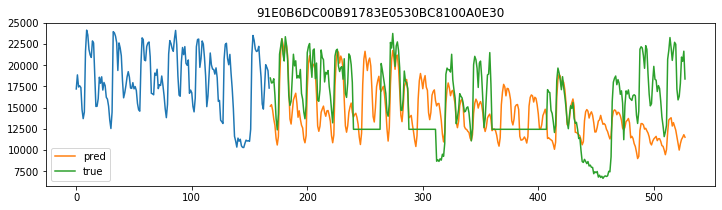

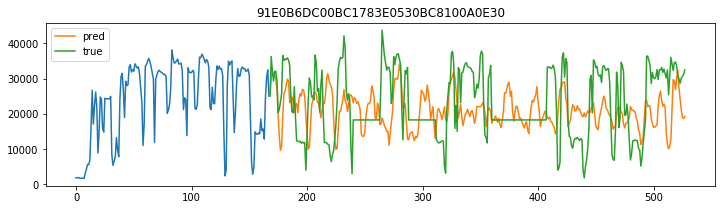

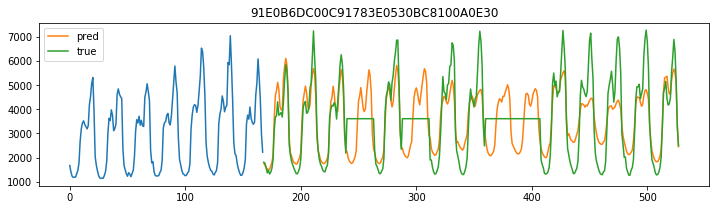

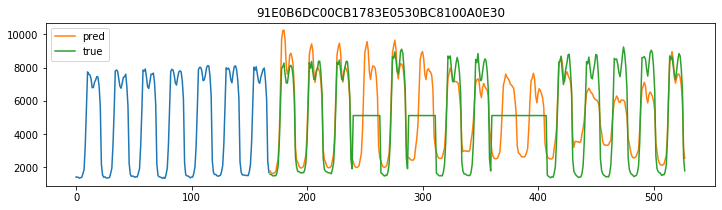

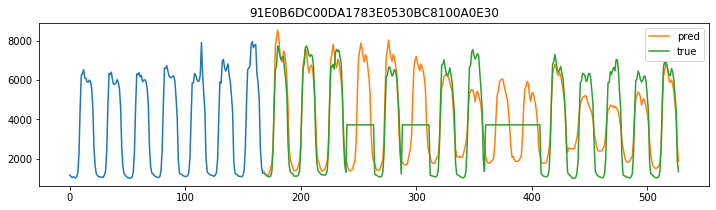

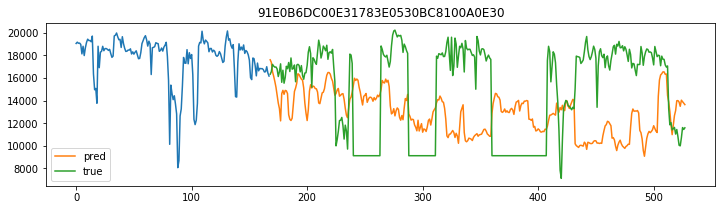

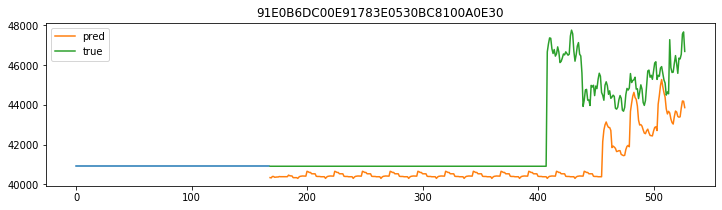

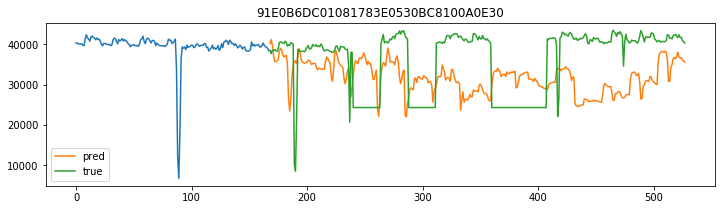

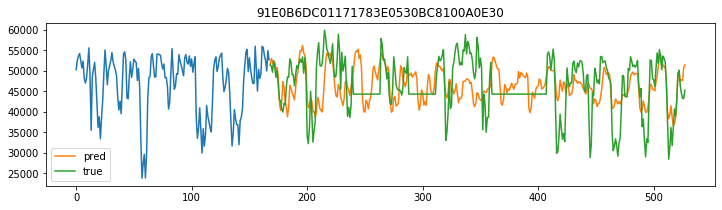

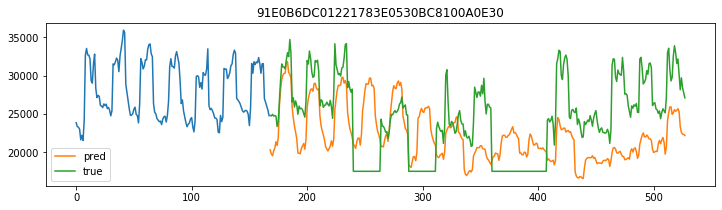

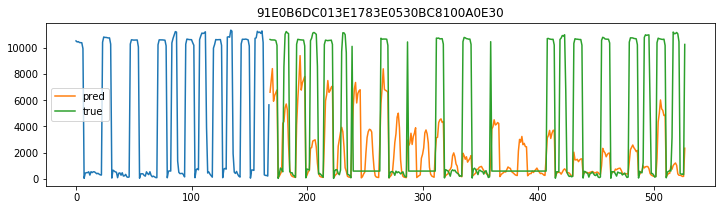

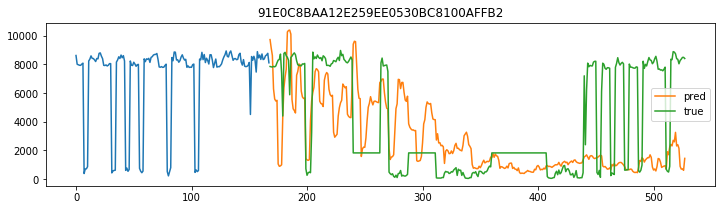

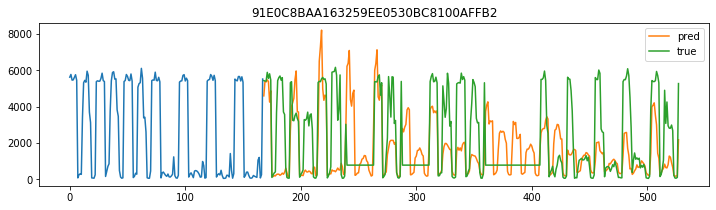

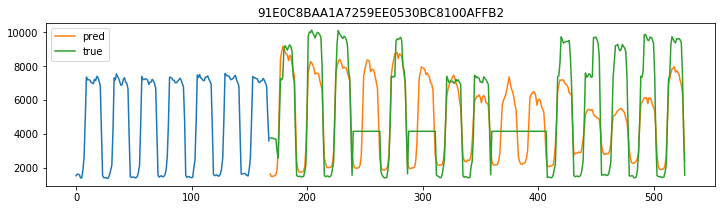

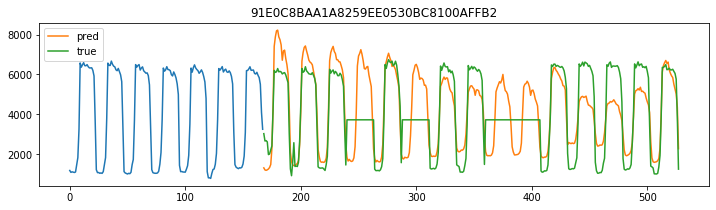

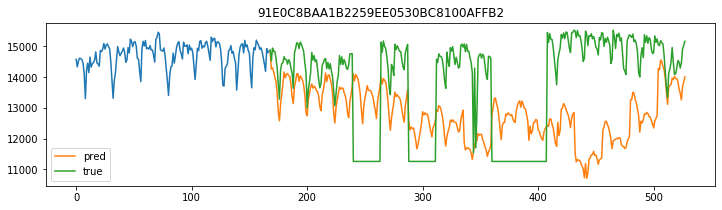

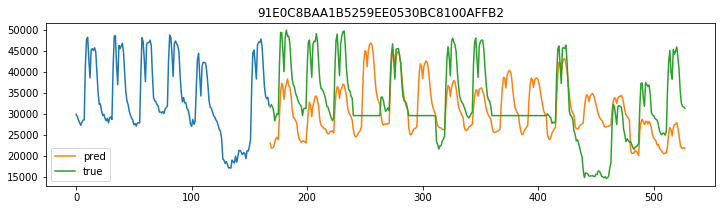

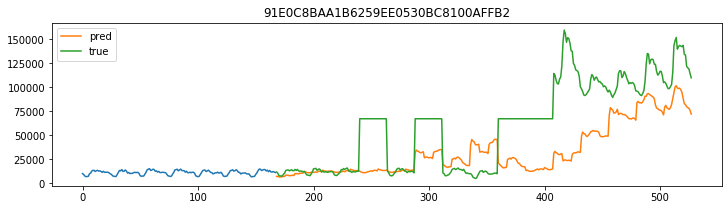

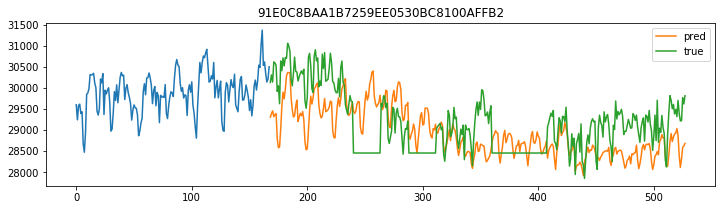

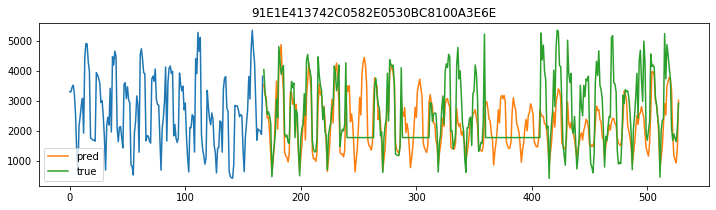

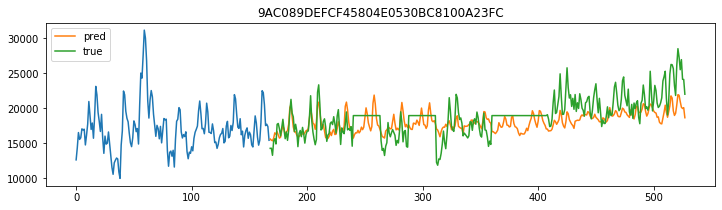

In [13]:
plot(x_true, y_true, y_pred)